In [162]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from copy import deepcopy

In [163]:
#open peptide file
train_peptides = pd.read_csv('amp-parkinsons-disease-progression-prediction/train_peptides.csv')
train_peptides['PeptideAbundance'] = train_peptides['PeptideAbundance'].fillna(0)
print(train_peptides.shape)
train_peptides.head()

(981834, 6)


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [164]:
train_proteins = pd.read_csv('amp-parkinsons-disease-progression-prediction/train_proteins.csv')
print(train_proteins.shape)
train_proteins.head()

(232741, 5)


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [165]:
train_clinical_data = pd.read_csv('amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
print(train_clinical_data.shape)
train_clinical_data.head()

(2615, 8)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [166]:
merged_df = pd.merge(train_proteins, train_peptides, on = ['visit_id','patient_id','visit_month','UniProt'])
merged_df.head()

,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance
0,55_0,0,55,O00391,11254.3,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,732430.0,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,732430.0,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,732430.0,SMEQNGPGLEYR,30838.7


In [167]:
merged_df_2 = pd.merge(merged_df, train_clinical_data, on=['visit_id', 'patient_id', 'visit_month'])
merged_df_2['PeptideAbundance_log'] = np.log(merged_df_2['PeptideAbundance'])
merged_df_2['NPX_log'] = np.log(merged_df_2['NPX'])

total_abundance = merged_df_2.groupby(['visit_id', 'patient_id', 'UniProt'], as_index=False)['PeptideAbundance'].sum()
total_abundance.rename(columns={'PeptideAbundance': 'TotalAbundance'}, inplace=True)

merged_df_2 = pd.merge(merged_df_2, total_abundance, on=['visit_id', 'patient_id', 'UniProt'], how='left')
merged_df_2['PeptideAbundanceRatio'] = merged_df_2['PeptideAbundance'] / merged_df_2['TotalAbundance']

print(merged_df_2.shape)
merged_df_2.head()


(941744, 16)


,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,PeptideAbundance_log,NPX_log,TotalAbundance,PeptideAbundanceRatio
0,55_0,0,55,O00391,11254.3,NEQEQPLGQWHLS,11254.3,10.0,6.0,15.0,NaN,NaN,9.328506,9.328506,11254.3,1.000000
1,55_0,0,55,O00533,732430.0,GNPEPTFSWTK,102060.0,10.0,6.0,15.0,NaN,NaN,11.533316,13.504123,732430.2,0.139344
2,55_0,0,55,O00533,732430.0,IEIPSSVQQVPTIIK,174185.0,10.0,6.0,15.0,NaN,NaN,12.067873,13.504123,732430.2,0.237818
3,55_0,0,55,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,10.0,6.0,15.0,NaN,NaN,10.213869,13.504123,732430.2,0.037244
4,55_0,0,55,O00533,732430.0,SMEQNGPGLEYR,30838.7,10.0,6.0,15.0,NaN,NaN,10.336526,13.504123,732430.2,0.042105


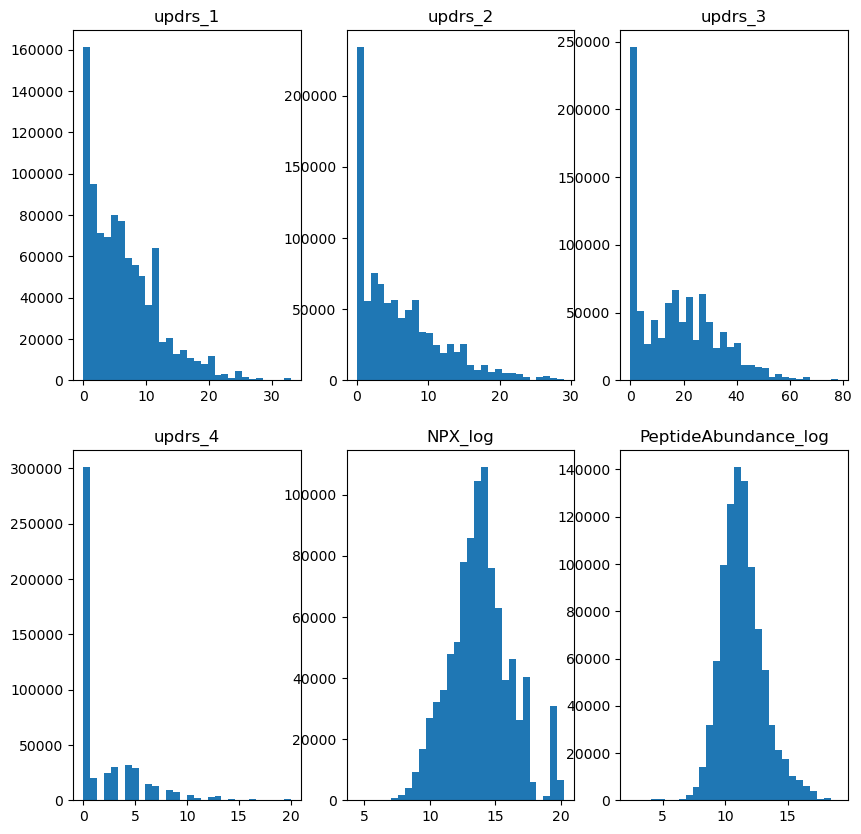

In [168]:
fig, axs = plt.subplots(2,3,figsize = (10,10))
axs = axs.flatten()
distro = ['updrs_1','updrs_2','updrs_3','updrs_4', 'NPX_log', 'PeptideAbundance_log']
for idx, var in enumerate(distro):
    axs[idx].hist(merged_df_2[var].dropna(),bins = 30)
    axs[idx].set_title(var)

In [169]:
pivot_df = merged_df_2.pivot(index = 'visit_id', columns = 'Peptide', values = 'PeptideAbundance')
pivot_df.fillna(0, inplace = True)
print(pivot_df.shape)
pivot_df.head()

(1068, 968)


Peptide,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
10053_0,6580710.0,31204.4,7735070.0,0.0,0.0,0.0,46620.3,236144.0,0.0,0.0,...,202274.0,0.00,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,0.0,7207.30
10053_12,6333510.0,52277.6,5394390.0,0.0,0.0,0.0,57554.5,108298.0,45885.4,0.0,...,201009.0,0.00,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
10053_18,7129640.0,61522.0,7011920.0,35984.7,17188.0,19787.3,36029.4,708729.0,5067790.0,30838.2,...,220728.0,0.00,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
10138_12,7404780.0,46107.2,10610900.0,0.0,20910.2,66662.3,55253.9,79575.5,6201210.0,26720.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
10138_24,13788300.0,56910.3,6906160.0,13785.5,11004.2,63672.7,36819.8,34160.9,2117430.0,15645.2,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,0.0,56977.6,4903.09


In [170]:
train_df = pd.merge(train_clinical_data, pivot_df, on='visit_id')
print(train_df['updrs_4'].isna().sum())
print(train_df.shape)
train_df.head()

499
(1068, 976)


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,8984260.0,53855.6,...,201158.0,16492.3,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
1,55_6,55,6,8.0,10.0,34.0,NaN,NaN,8279770.0,45251.9,...,171079.0,13198.8,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
2,55_12,55,12,10.0,10.0,41.0,0.0,On,8382390.0,53000.9,...,231772.0,17873.8,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1
3,55_36,55,36,17.0,18.0,51.0,0.0,On,10671500.0,58108.4,...,185290.0,18580.5,2659660.0,90936.9,679163.0,128593.0,203680.0,498621.0,52792.7,13973.7
4,942_6,942,6,8.0,2.0,21.0,NaN,NaN,6177730.0,42682.6,...,226314.0,6399.8,0.0,57571.4,480951.0,80001.2,79661.9,573300.0,48005.8,15674.1


In [171]:
X_1 = train_df.loc[~train_df['updrs_1'].isna(),'AADDTWEPFASGK':]
Y_1 = train_df.loc[~train_df['updrs_1'].isna(),'updrs_1']
reg = LinearRegression().fit(X_1, Y_1)
print(reg.score(X_1, Y_1))
X_2 = train_df.loc[~train_df['updrs_2'].isna(),'AADDTWEPFASGK':]
Y_2 = train_df.loc[~train_df['updrs_2'].isna(),'updrs_2']
reg = LinearRegression().fit(X_2, Y_2)
print(reg.score(X_2, Y_2))
X_3 = train_df.loc[~train_df['updrs_3'].isna(),'AADDTWEPFASGK':]
Y_3 = train_df.loc[~train_df['updrs_3'].isna(),'updrs_3']
reg = LinearRegression().fit(X_3, Y_3)
print(reg.score(X_3, Y_3))
X_4 = train_df.loc[~train_df['updrs_4'].isna(),'AADDTWEPFASGK':]
Y_4 = train_df.loc[~train_df['updrs_4'].isna(),'updrs_4']
reg = LinearRegression().fit(X_4, Y_4)
print(reg.score(X_4, Y_4))

0.9385181445546996
0.9599805254543051
0.9623536964258412
1.0


In [172]:
# create a pipeline
pipeline = Pipeline([
    ('scaling', StandardScaler()),  # scale the features
    ('reduce_dim', PCA(n_components = 10)),  # reduce dimensionality with PCA
    ('model', LinearRegression())  # train a linear regression model
])
pipeline_1 = deepcopy(pipeline)
pipeline_2 = deepcopy(pipeline)
pipeline_3 = deepcopy(pipeline)
pipeline_4 = deepcopy(pipeline)
# fit the pipeline on each dataset
pipeline_1.fit(X_1, Y_1)
pipeline_2.fit(X_2, Y_2)
pipeline_3.fit(X_3, Y_3)
pipeline_4.fit(X_4, Y_4)

Pipeline(steps=[('scaling', StandardScaler()),
                ('reduce_dim', PCA(n_components=10)),
                ('model', LinearRegression())])

In [173]:

# perform 5-fold cross-validation and compute R^2 scores for each dataset
scores_1 = cross_val_score(pipeline_1, X_1, Y_1, cv=5, scoring='r2')
scores_2 = cross_val_score(pipeline_2, X_2, Y_2, cv=5, scoring='r2')
scores_3 = cross_val_score(pipeline_3, X_3, Y_3, cv=5, scoring='r2')
scores_4 = cross_val_score(pipeline_4, X_4, Y_4, cv=5, scoring='r2')
# calculate the mean and standard deviation of the scores for each dataset
mean_score_1 = scores_1.mean()
std_score_1 = scores_1.std()

mean_score_2 = scores_2.mean()
std_score_2 = scores_2.std()

mean_score_3 = scores_3.mean()
std_score_3 = scores_3.std()

mean_score_4 = scores_3.mean()
std_score_4 = scores_3.std()

# print the mean and standard deviation of the scores for each dataset
print('Dataset 1 Mean score:', mean_score_1)
print('Dataset 1 Standard deviation:', std_score_1)

print('Dataset 2 Mean score:', mean_score_2)
print('Dataset 2 Standard deviation:', std_score_2)

print('Dataset 3 Mean score:', mean_score_3)
print('Dataset 3 Standard deviation:', std_score_3)

print('Dataset 4 Mean score:', mean_score_3)
print('Dataset 4 Standard deviation:', std_score_3)


Dataset 1 Mean score: -0.04202911483222145
Dataset 1 Standard deviation: 0.054596067665503685
Dataset 2 Mean score: -0.025561806001011787
Dataset 2 Standard deviation: 0.06205983992804085
Dataset 3 Mean score: 0.015693325985973682
Dataset 3 Standard deviation: 0.03373780930593376
Dataset 4 Mean score: 0.015693325985973682
Dataset 4 Standard deviation: 0.03373780930593376


In [176]:
test_proteins = pd.read_csv('amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv')
test_peptides = pd.read_csv('amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv')
test = pd.read_csv('amp-parkinsons-disease-progression-prediction/example_test_files/test.csv')

In [179]:
print(test_proteins.shape)
test_proteins.head()


(453, 6)


,visit_id,visit_month,patient_id,UniProt,NPX,group_key
0,50423_0,0,50423,O00391,33127.90,0
1,50423_0,0,50423,O00533,490742.00,0
2,50423_0,0,50423,O00584,43615.30,0
3,50423_0,0,50423,O14773,16486.60,0
4,50423_0,0,50423,O14791,2882.42,0


In [180]:
print(test_peptides.shape)
test_peptides.head()


(2057, 7)


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,group_key
0,50423_0,0,50423,O00391,AHFSPSNIILDFPAAGSAAR,22226.3,0
1,50423_0,0,50423,O00391,NEQEQPLGQWHLS,10901.6,0
2,50423_0,0,50423,O00533,GNPEPTFSWTK,51499.4,0
3,50423_0,0,50423,O00533,IEIPSSVQQVPTIIK,125492.0,0
4,50423_0,0,50423,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,23174.2,0


In [184]:
print(test.shape)
test

(16, 6)


,visit_id,visit_month,patient_id,updrs_test,row_id,group_key
0,3342_0,0,3342,updrs_1,3342_0_updrs_1,0
1,3342_0,0,3342,updrs_2,3342_0_updrs_2,0
2,3342_0,0,3342,updrs_3,3342_0_updrs_3,0
3,3342_0,0,3342,updrs_4,3342_0_updrs_4,0
4,50423_0,0,50423,updrs_1,50423_0_updrs_1,0
5,50423_0,0,50423,updrs_2,50423_0_updrs_2,0
6,50423_0,0,50423,updrs_3,50423_0_updrs_3,0
7,50423_0,0,50423,updrs_4,50423_0_updrs_4,0
8,3342_6,6,3342,updrs_1,3342_6_updrs_1,6
9,3342_6,6,3342,updrs_2,3342_6_updrs_2,6


In [192]:
test_df = pd.merge(test_proteins, test_peptides, on = ['visit_id','patient_id','visit_month','UniProt','group_key'])
test_df = test_df.pivot(index = 'visit_id', columns = 'Peptide', values = 'PeptideAbundance')
test_df.fillna(0, inplace = True)
test_df.head()

Peptide,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,AAVYHHFISDGVRK,AC(UniMod_4)DGINDC(UniMod_4)GDQSDELC(UniMod_4)C(UniMod_4)K,AC(UniMod_4)EPGVDYVYK,...,YSSDYFQAPSDYR,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
visit_id,,,,,,,,,,,,,,,,,,,,,
3342_6,7579140.0,74133.6,7580720.0,45426.9,10180.3,85589.0,39353.0,67733.7,3581.33,58295.7,...,31145.7,10359.8,3657330.0,47100.5,1007150.0,74598.6,127126.0,210763.0,46207.2,22031.60
50423_0,11087200.0,53998.5,9937660.0,25876.8,8013.8,42875.8,60326.2,63397.4,7721.18,75916.4,...,39620.5,15370.0,4137590.0,15217.0,83253.9,110941.0,112251.0,221372.0,46557.4,8527.23


In [195]:
X_Test = test_df.loc[:,'AADDTWEPFASGK':]
pipeline_1.predict(X_Test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- AAVYHHFISDGVRK
- AC(UniMod_4)DGINDC(UniMod_4)GDQSDELC(UniMod_4)C(UniMod_4)K
- AC(UniMod_4)EPGVDYVYK
- AEAQAQYSAAVAK
- AHFSPSNIILDFPAAGSAAR
- ...
Feature names seen at fit time, yet now missing:
- C(UniMod_4)C(UniMod_4)VEC(UniMod_4)PPC(UniMod_4)PAPPVAGPSVFLFPPKPK
- DALSSVQESQVAQQAR
- DC(UniMod_4)GSVDGVIKEVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK
- DRLDEVKEQVAEVR
- DSGVPDRFSGSGSGTDFTLK
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 1077 features, but StandardScaler is expecting 968 features as input.